### analyse of knowledge

In [2]:
import tiktoken

def get_encoding(model_name="gpt-4o"):
    # tiktoken 有些 alias，不同版本可能需要调整
    try:
        return tiktoken.encoding_for_model(model_name)
    except Exception:
        return tiktoken.get_encoding("cl100k_base")  # 通用 fallback

enc = get_encoding("qwen3")

def count_text_tokens(text: str) -> int:
    return len(enc.encode(text))

In [5]:
from collections import defaultdict
import json
import numpy as np

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def save_json(data, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

knowledges_path_gemini = "./knowledges/qwen3-235B_gemini-info_knowledges_retyped.json"
knowledges_path_fandom = "./knowledges/qwen3-235B_fandom_knowledges_retyped.json"
knowledges_fandom = load_json(knowledges_path_fandom)
knowledges_gemini = load_json(knowledges_path_gemini)
print(f'fandom 共加载{len(knowledges_fandom)}个角色')
print(f'gemini 共加载{len(knowledges_gemini)}个角色')

raw_fandom = load_json("../fandom/gt/character_fandom.json")
raw_gemini = load_json("../gen/results/gemini_search/gemini_acg_characters_profile.json")

tokens_fandom = {char: count_text_tokens(json.dumps(info, ensure_ascii=False)) for char, info in raw_fandom.items()}
tokens_gemini = {char: count_text_tokens(info['search_again_response']) for char, info in raw_gemini.items()}

def count_knowledges_type(knowledges, tokens=None):
    knowledges_count = []
    type_counter = defaultdict(int)
    for char, info in knowledges.items():
        try:
            knowledge_list = info['response']['knowledge_points']
        except:
            print('invalid: ', info)
            continue
        if tokens:
            knowledges_count.append(len(knowledge_list)/tokens[char] * 1000)
        else:
            knowledges_count.append(len(knowledge_list))
        if len(knowledge_list) == 0:
            print('zero: ' ,char)
        for knowledge in knowledge_list:
            type_counter[knowledge['type']] += 1

    print(f'valid {len(knowledges_count)}')
    return knowledges_count, type_counter

knowledges_count_fandom, type_counter_fandom = count_knowledges_type(knowledges_fandom, tokens=tokens_fandom)
knowledges_count_gemini, type_counter_gemini = count_knowledges_type(knowledges_gemini, tokens=tokens_gemini)
# knowledges_count_fandom, type_counter_fandom = count_knowledges_type(knowledges_fandom)
# knowledges_count_gemini, type_counter_gemini = count_knowledges_type(knowledges_gemini)

fandom 共加载1081个角色
gemini 共加载1109个角色
zero:  Rey (Star Wars)
zero:  Artoria Pendragon (Carnival Phantasm)
zero:  Mafuyu Satou (given)
zero:  Ritsuka Uenoyama (given)
zero:  Kurama (Yu Yu Hakusho: Ghostfiles)
zero:  Haruki Nakayama (given)
zero:  Cú  Chulainn (Carnival Phantasm)
zero:  Narrator (Pokémon)
zero:  Akihiko Kaji (given)
valid 1081
valid 1109


In [6]:
np.mean(knowledges_count_gemini)

np.float64(11.677896632017204)

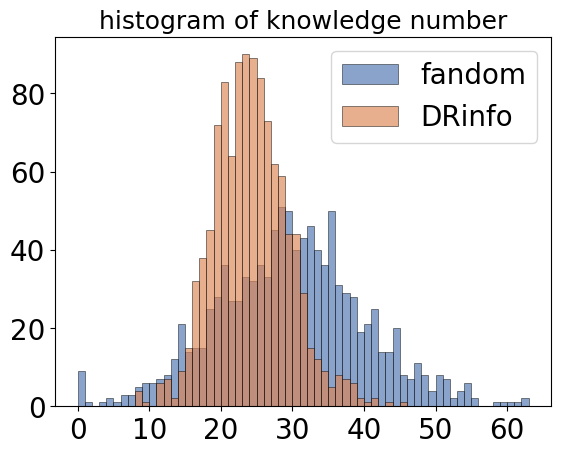

In [36]:
import matplotlib.pyplot as plt
import numpy as np

min_val = min(min(knowledges_count_fandom), min(knowledges_count_gemini))
max_val = max(max(knowledges_count_fandom), max(knowledges_count_gemini))

# 2️⃣ 固定“物理宽度”
bin_width = 1

# 3️⃣ 用 arange 生成统一 bins
bins = np.arange(min_val, max_val + bin_width, bin_width)

plt.figure()
plt.hist(knowledges_count_fandom, bins=bins, alpha=0.65, color='#4C72B0',edgecolor='black', linewidth=0.5, label="fandom")
plt.hist(knowledges_count_gemini, bins=bins, alpha=0.65, color='#DD8452',edgecolor='black', linewidth=0.5, label="DRinfo")

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=20)
# plt.title('knowledge density (per 1k token)', fontsize=18)
plt.title('histogram of knowledge number', fontsize=18)

plt.savefig('../fig/knowledge_hist.pdf', bbox_inches="tight")
plt.show()

plt.close()

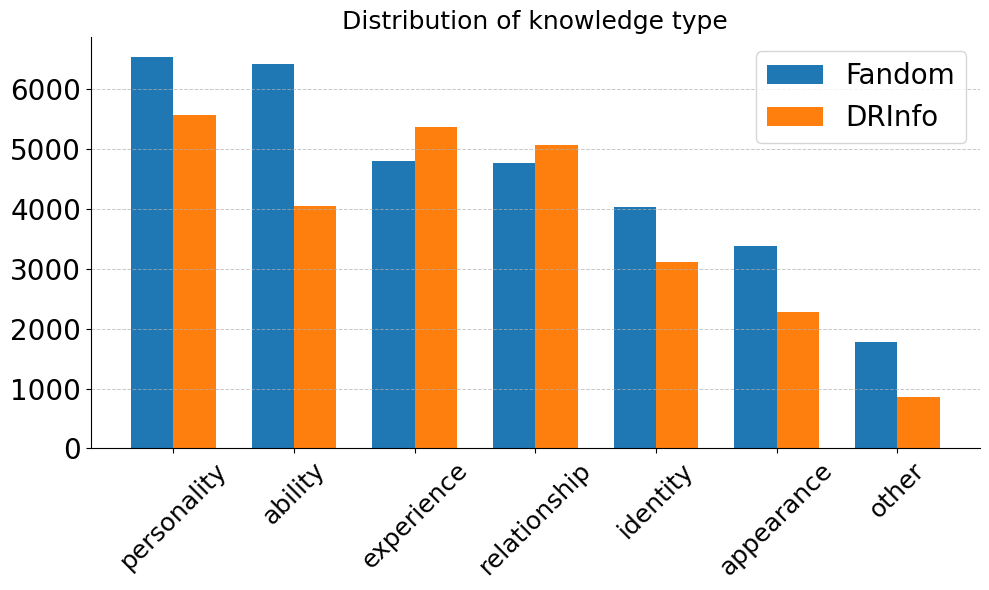

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# type_counter_fandom, type_counter_gemini
sorted_type_counter = dict(sorted(type_counter_fandom.items(), key=lambda item: item[1], reverse=True))

# 提取类别和数值
labels = list(sorted_type_counter.keys())
values1 = [type_counter_fandom[x] for x in labels]
values2 = [type_counter_gemini[x] for x in labels]

# 设置柱状图宽度和位置
x = np.arange(len(labels))
width = 0.35

# 绘图
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, values1, width, label='Fandom')
bars2 = plt.bar(x + width/2, values2, width, label='DRInfo')

# 添加背景横向虚线条纹
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# # 添加数值标签
# for bar in bars1 + bars2:
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
#              str(bar.get_height()), ha='center', va='bottom', fontsize=8)

# 坐标轴与标题
# plt.xlabel('Type', fontsize=12)
# plt.ylabel('Count', fontsize=12)
plt.title('Distribution of knowledge type', fontsize=18)
plt.xticks(x, labels, rotation=45, fontsize=18)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)

# 美化边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../fig/knowledge_type.pdf', bbox_inches="tight")
plt.show()

plt.close()

### 评估结果分析

#### 总体指标

In [ ]:
import json
from collections import defaultdict
from utils import load_file
# from rapidfuzz import fuzz, process

labels = ['supported', 'partially supported', 'irrelevant', 'contradicted']

def get_metrics(result: dict):
    supported = result.get('supported', 0)
    partially_supported = result.get('partially supported', 0)
    irrelevant = result.get('irrelevant', 0)
    contradicted = result.get('contradicted', 0)

    total = supported + partially_supported + irrelevant + contradicted
    recall = (supported + 0.5*partially_supported) / total
    irrelevant_rate = irrelevant / total
    contradict_rate = contradicted / total

    return {
        "total": total,
        "recall": recall,
        "irrelevant_rate": irrelevant_rate,
        "contradict_rate": contradict_rate
    }

def evaluate_total(results):
    ent_cnt = defaultdict(int)
    for entity_name, info in results.items():
        result = info['response']
        if not isinstance(result, list): continue
        for res in result:
            if 'evaluation' not in res:
                continue
            # 有的评估结果evidence和evaluation字段会弄反
            label = res['evidence'] if res['evidence'] in labels else res['evaluation']
            ent_cnt[label] += 1
    return ent_cnt


result_path_list = ["./results/qwen3-235B_fandom_gemini-info.json",
        "./results/qwen3-235B_fandom_gemini-info_ablation_20251123_124938.json",
        "./results/qwen3-235B_fandom_gemini-en-profile_20251123_124938.json",
        "./results/qwen3-235B_fandom_doubao-info_20251123_124938.json",
        "./results/qwen3-235B_fandom_doubao-zh-profile_20251123_124938.json",
        "./results/qwen3-235B_fandom_doubao-en-profile_20251123_124938.json",]
        # "./results/qwen3-235B_gemini-info_fandom_20251123_124938.json"]

tables = []
for results_path in result_path_list:
    results = load_file(results_path)
    ent_cnt = evaluate_total(results)
    metrics = get_metrics(ent_cnt)
    print(results_path)
    print(ent_cnt)
    print(metrics)
    print('----'*20)
    tables.append(metrics)


./results/qwen3-235B_fandom_gemini-info.json
defaultdict(<class 'int'>, {'supported': 18218, 'partially supported': 5580, 'irrelevant': 6971, 'contradicted': 804})
{'total': 31573, 'recall': 0.665378646311722, 'irrelevant_rate': 0.22078991543407342, 'contradict_rate': 0.02546479586988883}
--------------------------------------------------------------------------------
./results/qwen3-235B_fandom_gemini-info_ablation_20251123_124938.json
defaultdict(<class 'int'>, {'supported': 17198, 'partially supported': 5907, 'irrelevant': 7608, 'contradicted': 699})
{'total': 31412, 'recall': 0.6415223481472049, 'irrelevant_rate': 0.24220043295555838, 'contradict_rate': 0.02225264230230485}
--------------------------------------------------------------------------------
./results/qwen3-235B_fandom_gemini-en-profile_20251123_124938.json
defaultdict(<class 'int'>, {'supported': 18328, 'irrelevant': 7138, 'partially supported': 5046, 'contradicted': 1003})
{'total': 31515, 'recall': 0.6616214501031255

In [7]:
import pandas as pd
titles = ['gemini info(search again)', 'gemini info(search once)', 'gemini profile', 
          'doubao info', 'doubao profile(zh)', 'doubao profile(en)']
pd.DataFrame(tables, index=titles)

,total,recall,irrelevant_rate,contradict_rate
gemini info(search again),31573,0.665379,0.220790,0.025465
gemini info(search once),31412,0.641522,0.242200,0.022253
gemini profile,31515,0.661621,0.226495,0.031826
doubao info,31342,0.583610,0.260641,0.065599
doubao profile(zh),31408,0.581396,0.270441,0.076223
doubao profile(en),31415,0.533376,0.279834,0.104854


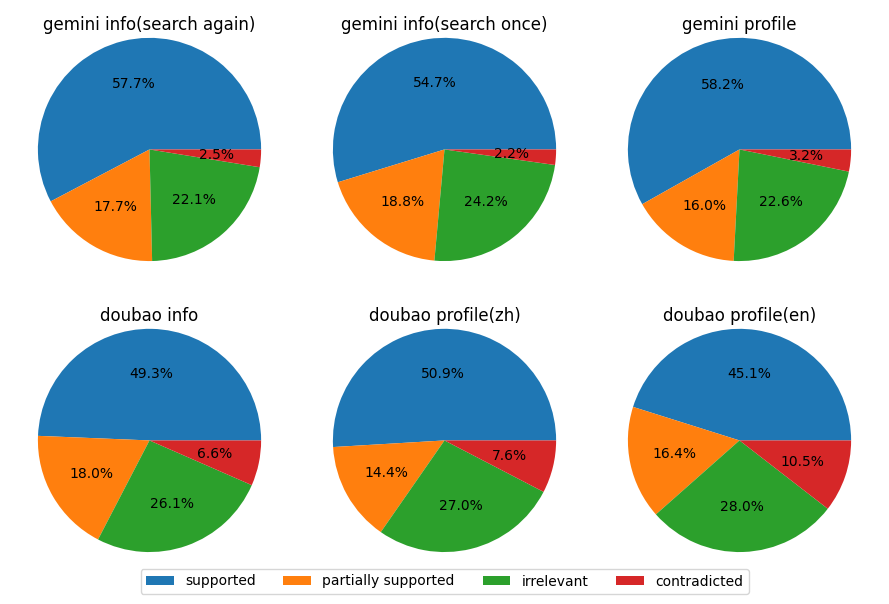

In [8]:
import matplotlib.pyplot as plt

labels = ['supported', 'partially supported', 'irrelevant', 'contradicted']
titles = ['gemini info(search again)', 'gemini info(search once)', 'gemini profile', 
          'doubao info', 'doubao profile(zh)', 'doubao profile(en)']

# 创建 2x2 图布局
fig, axes = plt.subplots(2, 3, figsize=(9, 6))  # 可以调整figsize来改变整体大小
axes = axes.flatten()  # 便于循环

for i, results_path in enumerate(result_path_list):
    results = load_file(results_path)
    ent_cnt = evaluate_total(results)

    sizes = [ent_cnt[label] for label in labels]
    wedges, texts, autotexts = axes[i].pie(sizes, autopct='%1.1f%%')
    axes[i].set_title(titles[i], y=0.9)
    # 记录第一张图的wedges用于统一图例
    if i == 0:
        legend_wedges = wedges
# 添加统一图例（放在底部中央）
fig.legend(legend_wedges, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.01))
# plt.subplots_adjust(bottom=0.15)  # 为图例留空间
plt.tight_layout()
plt.show()

#### 按知识点类别

In [9]:
import json
from collections import defaultdict
import pandas as pd
from utils import load_file
#556
# result_path = "./results/gpt-4o-mini_fandom_gemini_search_20251024_180040.json"

def evaluate_type(knowledges, results):
    type_entity_counter = defaultdict(lambda : defaultdict(int))

    valid = 0
    for entity_name, info in results.items():
        result = info['response']
        knowledge = knowledges[entity_name]['response']['knowledge_points']

        if not isinstance(result, list) or not isinstance(knowledge, list): continue
        for res in result:
            if 'evaluation' not in res:
                continue
            tp = knowledge[int(res['id'])-1]['type']
            label = res['evidence'] if res['evidence'] in labels else res['evaluation']
            type_entity_counter[tp][label] += 1
        valid += 1
    print('valid: ', valid)
    return type_entity_counter

def calculate_type_metrics(type_entity_counter):
    table = []
    for tp, cnt in type_entity_counter.items():
        metrics = get_metrics(cnt)
        table.append({'type': tp, **metrics})
    table.sort(key=lambda x: x['total'], reverse=True)
    return table

result_path_list = ["./results/qwen3-235B_fandom_gemini-info.json",
        "./results/qwen3-235B_fandom_gemini-info_ablation_20251123_124938.json",
        "./results/qwen3-235B_fandom_gemini-en-profile_20251123_124938.json",
        "./results/qwen3-235B_fandom_doubao-info_20251123_124938.json",
        "./results/qwen3-235B_fandom_doubao-zh-profile_20251123_124938.json",
        "./results/qwen3-235B_fandom_doubao-en-profile_20251123_124938.json",]

tables = []
knowledges_path = "./knowledges/qwen3-235B_fandom_knowledges_retyped.json"
knowledges = load_file(knowledges_path)
for results_path in result_path_list:
    results = load_file(results_path)
    type_entity_counter = evaluate_type(knowledges, results)
    tb = calculate_type_metrics(type_entity_counter)
    print(results_path)
    print(pd.DataFrame(tb))
    tables.append(pd.DataFrame(tb))

valid:  1069
./results/qwen3-235B_fandom_gemini-info.json
           type  total    recall  irrelevant_rate  contradict_rate
0   personality   6518  0.816662         0.117828         0.008745
1       ability   6399  0.613690         0.286920         0.014690
2    experience   4774  0.604210         0.270214         0.052786
3  relationship   4746  0.683207         0.196797         0.030552
4      identity   4007  0.746569         0.118043         0.027702
5    appearance   3364  0.576249         0.232461         0.030618
6         other   1765  0.397167         0.503116         0.023796
valid:  1065
./results/qwen3-235B_fandom_gemini-info_ablation_20251123_124938.json
           type  total    recall  irrelevant_rate  contradict_rate
0   personality   6479  0.807764         0.122241         0.008335
1       ability   6363  0.574807         0.324218         0.011787
2    experience   4751  0.577984         0.302252         0.040834
3  relationship   4726  0.656263         0.218790      

In [10]:
tables[0]

,type,total,recall,irrelevant_rate,contradict_rate
0,personality,6518,0.816662,0.117828,0.008745
1,ability,6399,0.613690,0.286920,0.014690
2,experience,4774,0.604210,0.270214,0.052786
3,relationship,4746,0.683207,0.196797,0.030552
4,identity,4007,0.746569,0.118043,0.027702
5,appearance,3364,0.576249,0.232461,0.030618
6,other,1765,0.397167,0.503116,0.023796


In [11]:
knowledges_reverse = load_file("./knowledges/qwen3-235B_gemini-info_knowledges_retyped.json")
results_reverse = load_file("./results/qwen3-235B_gemini-info_fandom_20251123_124938.json")
type_entity_counter_reverse = evaluate_type(knowledges_reverse, results_reverse)
tb_reverse = calculate_type_metrics(type_entity_counter_reverse)
pd.DataFrame(tb_reverse)

valid:  1078


,type,total,recall,irrelevant_rate,contradict_rate
0,personality,5404,0.867598,0.092894,0.002591
1,experience,5215,0.734995,0.192138,0.025503
2,relationship,4915,0.776501,0.135707,0.011190
3,ability,3941,0.837732,0.109363,0.006851
4,identity,3018,0.864977,0.085156,0.010934
5,appearance,2220,0.813514,0.083784,0.010360
6,other,834,0.724221,0.185851,0.031175


valid:  1069


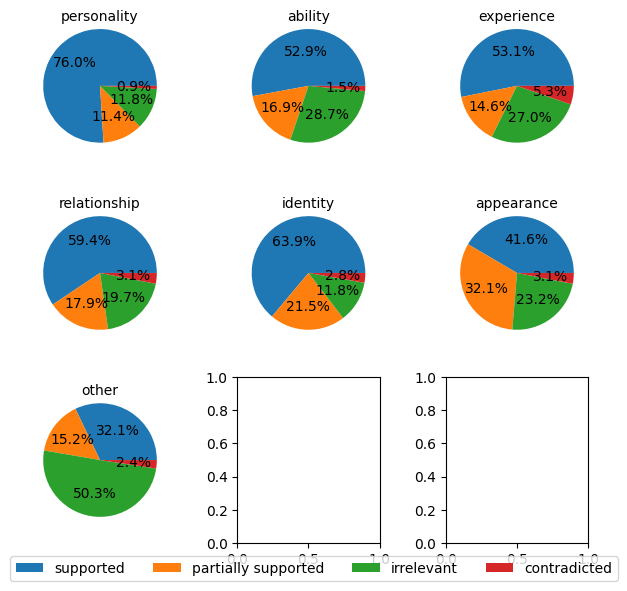

In [12]:
labels = ['supported', 'partially supported', 'irrelevant', 'contradicted']
# titles = ['gemini 2', 'gemini 1', 'doubao(zh)', 'doubao(en)']

# 创建 2x2 图布局
fig, axes = plt.subplots(3, 3, figsize=(6, 6))  # 可以调整figsize来改变整体大小
axes = axes.flatten()  # 便于循环

results = load_file(result_path_list[0])
tb = evaluate_type(knowledges, results)

for i, tp in enumerate(sorted(tb, key=lambda x: sum(tb[x].values()), reverse=True)):

    sizes = [tb[tp][label] for label in labels]
    wedges, texts, autotexts = axes[i].pie(sizes, autopct='%1.1f%%')
    axes[i].set_title(tp, y=0.9, fontsize=10)
    # 记录第一张图的wedges用于统一图例
    if i == 0:
        legend_wedges = wedges
# 添加统一图例（放在底部中央）
fig.legend(legend_wedges, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.01))
# plt.subplots_adjust(bottom=0.15)  # 为图例留空间
plt.tight_layout()
plt.show()

### Human evaluation

In [ ]:
# sample knowledge points

import random
import json
from utils import load_file
from collections import defaultdict

def sample_knowledges(results, knowledges=None, k=100, seed=1024):
    random.seed(seed)
    total_knowledges = []
    for char, info in results.items():
        if not isinstance(info['response'], list):
            continue
        for item in info['response']:
            item['name'] = char
            if knowledges:
                item['type'] = knowledges[char]['response']['knowledge_points'][int(item['id'])-1]['type']
        total_knowledges.extend(info['response'])
    res = random.sample(total_knowledges, k=k)
    return res

def sample_knowledges_by_evaluation(results, knowledges=None, k=100, seed=1024):
    random.seed(seed)
    
    # 1. 先按照 evaluation 分组
    eval_groups = defaultdict(list)

    for char, info in results.items():
        if not isinstance(info.get('response'), list):
            continue

        for item in info['response']:
            item['name'] = char

            if knowledges:
                item['type'] = knowledges[char]['response']['knowledge_points'][int(item['id']) - 1]['type']
            item['human'] = None
            eval_type = item.get('evaluation', 'unknown')
            eval_groups[eval_type].append(item)

    # 2. 每个 evaluation 采样 k 个
    res = {}
    for eval_type, items in eval_groups.items():
        if len(items) <= k:
            res[eval_type] = items
        else:
            res[eval_type] = random.sample(items, k)

    return res

results = load_file("./results/qwen3-235B_fandom_gemini-info.json")
knowledges = load_file("./knowledges/qwen3-235B_fandom_knowledges_retyped.json")
sampled = sample_knowledges_by_evaluation(results, knowledges, k=100)
with open('sampled_knowledges.json', 'w', encoding='utf-8') as f:
    json.dump(sampled, f, ensure_ascii=False, indent=2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from utils import load_file

# 你的四个固定类别（顺序必须固定）
labels = ["supported", "partially supported", "irrelevant", "contradicted"]
display_labels = [l[:3].upper() for l in labels]
data = load_file("sampled_knowledges.json")

# 从数据中提取真实标签和预测标签
y_true = [x["human"] for ls in data.values() for x in ls]
y_pred = [x["evaluation"] for ls in data.values() for x in ls]

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred, labels=labels)

# 输出文本版混淆矩阵
print("Confusion Matrix:")
print(cm)

# 输出 Precision / Recall / F1
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=labels, digits=4))

# ========== 画图 ==========
fig, ax = plt.subplots(figsize=(6.5, 5.5))  # 适合双栏论文

# 使用论文友好的 colormap
im = ax.imshow(cm, cmap="Blues")

# 坐标轴刻度
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(display_labels, fontsize=13)
ax.set_yticklabels(display_labels, fontsize=13)

# 旋转 x 轴标签
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# 在格子里标数字（更大 + 自动颜色）
max_val = cm.max()
for i in range(len(labels)):
    for j in range(len(labels)):
        val = cm[i, j]
        ax.text(
            j, i, f"{val}",
            ha="center",
            va="center",
            fontsize=18,
            fontweight="bold",
            color="white" if val > max_val * 0.5 else "black"
        )

# 轴标签（标题建议放到 caption，这里可保留）
ax.set_xlabel("Predicted Label (LLM)", fontsize=15)
ax.set_ylabel("True Label (Human)", fontsize=15)

# 去掉多余边框（论文风格）
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# 添加 colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

### calculate tokens

In [ ]:
from prompt import COMPARE_PROMPT
from utils import load_file
import tiktoken

def get_encoding(model_name="gpt-4o"):
    # tiktoken 有些 alias，不同版本可能需要调整
    try:
        return tiktoken.encoding_for_model(model_name)
    except Exception:
        return tiktoken.get_encoding("cl100k_base")  # 通用 fallback

enc = get_encoding("qwen3")

def count_text_tokens(text: str) -> int:
    return len(enc.encode(text))

gt_konwledge_file = "/home/sjy/DRCharater-main/evaluation/knowledges/qwen3-235B_fandom_20251122_025126.json"
profile_file = "/home/sjy/DRCharater-main/gen/results/gemini_search/gemini_acg_characters_profile.json"
gt = load_file(gt_konwledge_file)
print(f"成功读取 {gt_konwledge_file}，共 {len(gt)} 条记录")
profile_full = load_file(profile_file)
print(f"成功读取 {profile_file}，共 {len(profile_full)} 条记录")

entity_key = "search_again_response"
# if language == 'en':  entity_key = 'english_profile'
# elif language == 'zh': entity_key = 'chinese_profile'

entities_data = []
for entity_name in gt.keys():
    if not isinstance(gt[entity_name]['response'], dict) or not gt[entity_name]['response'].get('knowledge_points', None): continue
    if entity_name in profile_full:
        kownledges = gt[entity_name]['response']['knowledge_points']
        kowledge_list = [knowledge['knowledge'] for knowledge in kownledges]
        if entity_key is None and profile_full[entity_name]:
            character_text = json.dumps(profile_full[entity_name], ensure_ascii=False)
            entities_data.append((entity_name, kowledge_list, character_text))
        elif profile_full[entity_name].get(entity_key, None):
            character_text = profile_full[entity_name][entity_key]
            entities_data.append((entity_name, kowledge_list, character_text))

tokens = []
for entity_info in entities_data:
    entity_name, kowledge_list, character_text = entity_info
    prompt = COMPARE_PROMPT.replace('{knowledge_list}', json.dumps(kowledge_list, ensure_ascii=False, indent=2)).replace('{character_text}', character_text)
    tokens.append(count_text_tokens(prompt))


成功读取 /home/sjy/DRCharater-main/evaluation/knowledges/qwen3-235B_fandom_20251122_025126.json，共 1081 条记录
成功读取 /home/sjy/DRCharater-main/gen/results/gemini_search/gemini_acg_characters_profile.json，共 1109 条记录


In [ ]:
sum(tokens), len(tokens), sum(tokens)/len(tokens), max(tokens)

(3684619, 1067, 3453.2511715089036)

In [14]:
from utils import load_file
import tiktoken
import json

def get_encoding(model_name="gpt-4o"):
    # tiktoken 有些 alias，不同版本可能需要调整
    try:
        return tiktoken.encoding_for_model(model_name)
    except Exception:
        return tiktoken.get_encoding("cl100k_base")  # 通用 fallback

enc = get_encoding("qwen3")

def count_text_tokens(text: str) -> int:
    return len(enc.encode(text))

gemini_know = load_file("./knowledges/qwen3-235B_gemini-info_knowledges_retyped.json")
gemini_profile = load_file("../gen/results/gemini_search/gemini_acg_characters_profile.json")

info_density = []

for char, resp in gemini_know.items():
    know_list = resp['response']['knowledge_points']
    profile = gemini_profile[char]['search_again_response']
    info_density.append(len(know_list)/count_text_tokens(profile) * 1000)


In [15]:
fandom_know = load_file("./knowledges/qwen3-235B_fandom_knowledges_retyped.json")
fandom_info = load_file("../fandom/gt/character_fandom.json")

info_density = []

for char, resp in fandom_know.items():
    know_list = resp['response']['knowledge_points']
    profile = json.dumps(fandom_info[char], ensure_ascii=False)
    info_density.append(len(know_list)/count_text_tokens(profile) * 1000)

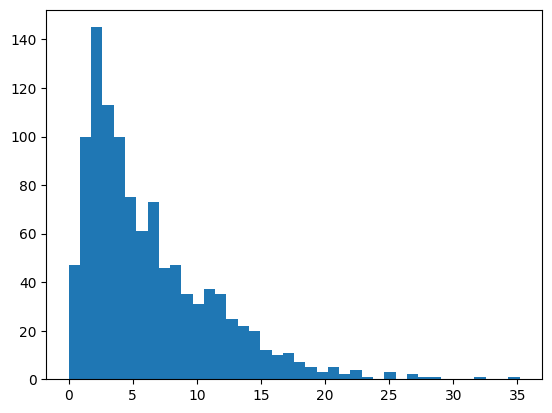

In [17]:
import matplotlib.pyplot as plt

plt.hist(info_density, bins=40)
plt.show()

In [16]:
sum(info_density)/len(info_density)

6.325699019431485